In [1]:
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install torch
!pip install numpy

Imports & Environment Setup

In [5]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# -------------------------------------
# Create the CartPole environment
# -------------------------------------
# Observation space: [cart position, cart velocity, pole angle, pole velocity]
# Action space: 0 = left, 1 = right
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("State dim:", state_dim)
print("Action dim", action_dim)


State dim: 4
Action dim 2


Define The DQN Network

In [6]:
# ------------------------------------------------------
# This neural network approximates the Q-values:
# Q(s, a) for all actions a in each state s
# ------------------------------------------------------
class DQN(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(DQN,self).__init__()

    # Two fully connected hidden layers
    self.fc1 = nn.Linear(state_dim, 128)
    self.fc2 = nn.Linear(128, 128)

    # Output layer: one Q-value per action
    self.out = nn.Linear(128, action_dim)

  def forward(self, x):
    # Pass input through network with ReLU activation
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    return self.out(x)

Replay Buffer

In [11]:

# --------------------------------------------------
# Replay buffer stores past transitions:
# (state, action, reward, next_state, done)
# This stabilizes learning by sampling random batches.
# --------------------------------------------------
class ReplayBuffer:
  def __init__(self, max_size=100000):
    self.buffer = deque(maxlen=max_size)

  def add(self, transition):
    self.buffer.append(transition)

  def sample(self, batch_size=64):
    # Randomly sample "batch_size" transitions
    batch = random.sample(self.buffer, batch_size)

    # Unpack batch into tensors
    states, actions, rewards, next_states, dones = zip(*batch)

    return(
        torch.tensor(states, dtype=torch.float32),
        torch.tensor(actions, dtype=torch.int64),
        torch.tensor(rewards, dtype=torch.float32),
        torch.tensor(next_states, dtype=torch.float32),
        torch.tensor(dones, dtype=torch.float32)
    )

  def size(self):
    return len(self.buffer)

Training Loop

In [29]:
# ------------------------
# Hyperparameters
# ------------------------
gamma = 0.99           # future reward discount factor
lr = 1e-3              # learning rate
batch_size = 64        # training batch size
episodes = 500         # number of episodes to train for

epsilon = 1.0          # exploration probability (start high)
epsilon_min = 0.05     # minimum exploration
epsilon_decay = 0.995  # decay rate for epsilon

# Replay buffer + networks
buffer = ReplayBuffer(max_size=100000)

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)

# Initialize target network with same weights
target_net.load_state_dict(policy_net.state_dict())

# taget net is not trained directly
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)

# Update target network every N episodes
target_update_freq = 10

reward_history = []

# -------------------------------------------
# Helper: epsilon-greedy action selection
# -------------------------------------------
def select_action(state, epsilon):
  # Explore with probability epsilon
  if random.random() < epsilon:
    return env.action_space.sample()

  # Otherwise use the policy network
  state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
  with torch.no_grad():
    q_values = policy_net(state_t)
    action = torch.argmax(q_values).item()
  return action

# -------------------------------------------
# Main training loop
# -------------------------------------------
for ep in range(episodes):
  # Reset environment
  state, _= env.reset()
  done = False
  total_reward = 0

  while not done:
    # Choose action (ε-greedy)
    action = select_action(state, epsilon)

    # Take step in environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # Store transition in replay buffer
    buffer.add((state, action, reward, next_state, done))

    state = next_state
    total_reward += reward

    # ---------------------------
    # Train the DQN using replay
    # ---------------------------
    if buffer.size() > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)

      # Current Q-values from target network
      q_vals = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

      # Target Q-values from target network
      with torch.no_grad():
        next_q_vals = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q_vals * (1 - dones)

      # Compute loss between Q-values and targets
      loss = nn.MSELoss()(q_vals, targets.detach())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Decay exploration
  epsilon = max(epsilon_min, epsilon * epsilon_decay)

  reward_history.append(total_reward)

  # Periodically update target network
  if (ep + 1) % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

  if (ep + 1) % 50 == 0:
      print(f"Episode {ep+1}/{episodes} | Reward: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

print("Training Completed!")

Episode 50/500 | Reward: 17.0 | Epsilon: 0.778
Episode 100/500 | Reward: 11.0 | Epsilon: 0.606
Episode 150/500 | Reward: 38.0 | Epsilon: 0.471
Episode 200/500 | Reward: 105.0 | Epsilon: 0.367
Episode 250/500 | Reward: 37.0 | Epsilon: 0.286
Episode 300/500 | Reward: 18.0 | Epsilon: 0.222
Episode 350/500 | Reward: 71.0 | Epsilon: 0.173
Episode 400/500 | Reward: 191.0 | Epsilon: 0.135
Episode 450/500 | Reward: 139.0 | Epsilon: 0.105
Episode 500/500 | Reward: 110.0 | Epsilon: 0.082
Training Completed!


Plot Training Curve

In [30]:
print("Length of reward_history:", len(reward_history))
print("First 10 values:", reward_history[:10])
print("Last 10 values:", reward_history[-10:])



Length of reward_history: 500
First 10 values: [16.0, 20.0, 16.0, 22.0, 12.0, 18.0, 14.0, 23.0, 11.0, 42.0]
Last 10 values: [110.0, 119.0, 228.0, 135.0, 115.0, 180.0, 131.0, 125.0, 108.0, 110.0]


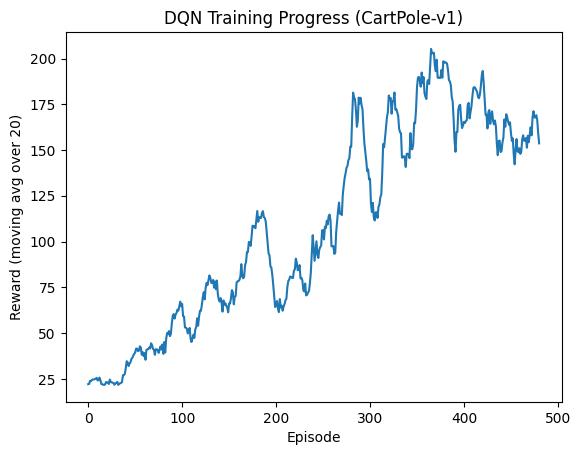

In [32]:
import numpy as np
window = 20
moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel(f"Reward (moving avg over {window})")
plt.title("DQN Training Progress (CartPole-v1)")
plt.show()


Test the Trained Agent

In [33]:
# ----------------------------------------------------
# Test the final trained agent with no exploration
# ----------------------------------------------------
test_env = gym.make("CartPole-v1", render_mode="human")

state, _ = test_env.reset()
done = False
total_reward = 0

while not done:
  # Always exploit best action
  action = select_action(state, epsilon=0.0)

  next_state, reward, terminated, truncated, _ = test_env.step(action)
  done = terminated or truncated
  total_reward += reward
  state = next_state

print("Test episode reward:", total_reward)

Test episode reward: 132.0
